In [3]:
import sys
sys.path.append('/home/rotation3/complex-coor-pred/')

In [ ]:
import random
import torch
import numpy as np
from config import device
from data.MyData import Data
from tools.cal_lddt_multiseq import cal_lddt
from pLDDT.pLDDT import pLDDT
import seaborn as sns
import matplotlib.pyplot as plt

train_data_path = '/home/rotation3/complex-coor-pred/data/train22310.3besm2.h5'
test_data_path = '/home/rotation3/complex-coor-pred/data/valid2000.3besm2.h5'
xyz_path = '/home/rotation3/complex-coor-pred/data/xyz.h5'
sorted_train_file = "/home/rotation3/complex-coor-pred/data/sorted_train_list.txt"
test_file = "/home/rotation3/complex-coor-pred/data/valid_list.txt"

net_pt_name = '/home/rotation3/complex-coor-pred/model/checkpoint/CoorNet_VII/epoch34.pt'
pLDDT_name = '/home/rotation3/complex-coor-pred/pLDDT/plddt_checkpoints/Full_train/epoch7_mark.pt'
# net_pt_name = '/home/rotation3/coor-pred/model/checkpoint/l2_II/epoch29.pt'
net_pt = torch.load(net_pt_name)
net_pt.eval()

pLDDT = torch.load(pLDDT_name)
pLDDT.eval()

train_mode = False
test_ls = range(1988)

diff_ls = []
for index in test_ls:
    if train_mode:
        path = train_data_path
        file_list = sorted_train_file
    else:
        path = test_data_path
        file_list = test_file

    ds = Data(path, xyz_path, file_list, train_mode=False)   #此处的train_mode控制蛋白会不会被tunc
    embed, atten, coor_label, L, pdb_index = ds[index]
    embed = embed.to(device)
    atten = atten.to(device)
    coor_label = coor_label.to(device)
    embed.unsqueeze_(0)
    atten.unsqueeze_(0)
    coor_label.unsqueeze_(0)

    with torch.no_grad():
        pred_coor_4_steps, pred_x2d = net_pt(embed, atten)
        pred_coor = pred_coor_4_steps[-1]   # 取出最后一个Block预测出的coor
        # pred_coor = net_pt(embed, atten)
        # pred_coor = pred_coor.reshape(1,L,L,3)

    pred_lddt = pLDDT(pred_coor, pred_x2d).squeeze()

    eps = 1e-5
    pred_coor = pred_coor.unsqueeze(-2) - pred_coor.unsqueeze(-3)
    pred_coor = ((pred_coor**2).sum(dim=-1) + eps) ** 0.5
    coor_label = ((coor_label**2).sum(dim=-1) + eps) ** 0.5
    # print(pred_coor.shape, coor_label.shape)
    lddt = cal_lddt(pred_coor, coor_label)
    lddt = lddt.squeeze()
    # lddt = (lddt.mean(dim=-1)).max()
    # lddt = lddt.item()
    # lddt_ls.append(lddt)
    print(pred_lddt.shape, lddt.shape)
    diff = torch.mean(abs(pred_lddt - lddt))
    diff_ls.append(diff.item())

# print(np.mean(diff_ls))

    sns.heatmap(pred_lddt.detach().cpu().numpy(),cmap="YlGnBu")
    plt.show()
    sns.heatmap(lddt.detach().cpu().numpy(),cmap="YlGnBu")
    plt.show()
    sns.heatmap(abs(pred_lddt - lddt).detach().cpu().numpy(),cmap="Blues")
    plt.show()


# print(np.mean(lddt_ls))
# np.save('/home/rotation3/complex-coor-pred/pLDDT/plddt.npy', np.array(diff_ls))


In [12]:
np.save('/home/rotation3/complex-coor-pred/pLDDT/plddt.npy', np.array(diff_ls))

/tmp/ipykernel_16308/224104538.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.array(a),color="steelblue",bins=100,kde=True,label='Multi-Block')


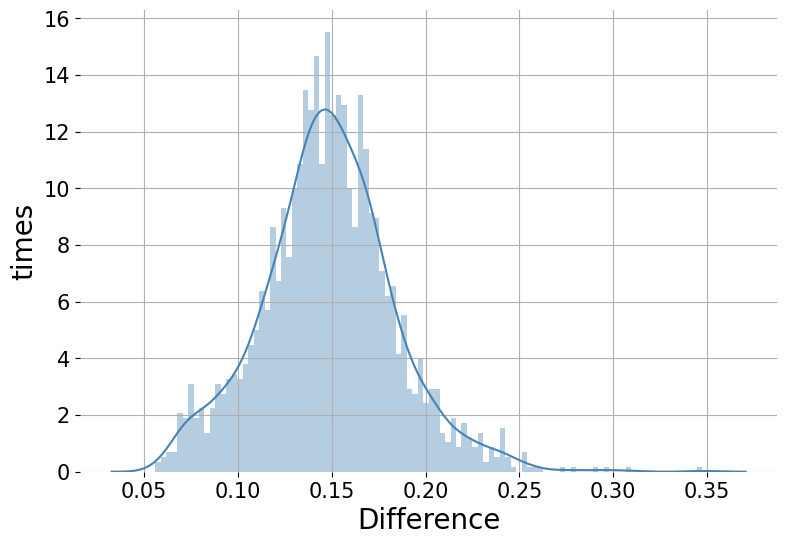

In [5]:
import random
import torch
import numpy as np
from config import device
from data.MyData import Data
from tools.cal_lddt_multiseq import cal_lddt
from pLDDT.pLDDT import pLDDT
import seaborn as sns
import matplotlib.pyplot as plt

a = np.load('/home/rotation3/complex-coor-pred/pLDDT/plddt.npy')
fig = plt.figure(figsize=(9,6))  #设置画布的大小
sns.set_palette("hls")       #设置所有图的颜色，使用hls色彩空间
sns.distplot(np.array(a),color="steelblue",bins=100,kde=True,label='Multi-Block')
plt.xlabel('Difference',fontsize=20)           #添加x轴标签，并改变字体
plt.ylabel('times',fontsize=20)   #添加y轴变浅，并改变字体
plt.grid(linestyle='-')   #添加网格线
plt.xticks(fontsize=15)   #改变x轴字体大小
plt.yticks(fontsize=15)   #改变y轴字体大小
sns.despine(ax=None, top=True, right=True, left=True,bottom=True)    #将图像的框框删掉
plt.savefig('pLDDT_difference' + ".png")   #保存图片